#**TUTORIAL GTSAM EM PYTHON**

FUIMS 24/25: MEEC - SA

*   João Campanhã (1201033)
*   Marco Almeida (1201565)



Este tutorial foi inspirado num dos exemplos encontrados no tutorial de Jing Dong: [GTSAM Programming Tutorial](https://dongjing3309.github.io/files/gtsam-tutorial.pdf). Contudo, a nossa abordagem é centrada no Python e utiliza a versão mais recente do GTSAM.

Neste tutorial o GTSAM 4.2 é instalado via pip.
Normalmente usa-se o seguinte comando para instalar o package [gtsam](https://pypi.org/project/gtsam/):

*   *pip install gtsam*

Também é possível utilizar o [gtbook](https://pypi.org/project/gtbook/), que inclui a versão mais recente do GTSAM e alguns pre-exemplos com os respetivos gráficos de plot.

Ambos são fontes oficiais e mantidos pelo próprio [Frank Dellaert](https://www.google.com/search?client=firefox-b-d&q=+Frank+Dellaert).


In [ ]:
#Instalar GTSAM 4.2 via pip:

# %pip -q install gtbook
%pip -q install gtsam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 17.6 MB/s eta 0:00:00


##**Import dos packages necessários**

Primeiro é necessário realizar os imports necessários, neste caso do **gtsam**, **numpy** e do **matplotlib**.

In [ ]:
import gtsam
from gtsam import symbol, Pose2, Point2
import gtsam.utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from typing import List, Optional
from functools import partial

##**Construir um modelo de factor graph**

Pretende-se representar o seguinte modelo/problema de SLAM em *factor graph*:

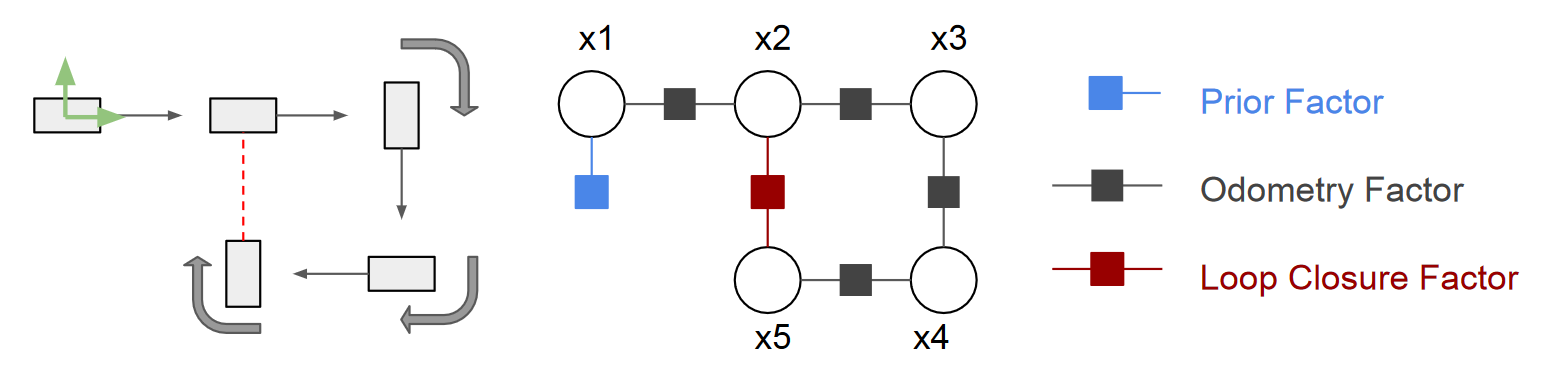

Neste caso são adicionados 3 tipos de factors:

*   Prior Factor: Restrição inicial e pose do robot
*   Odometry Factors: Modela as mudanças de posição
*   Loop Closure Factor: Reconhecimento do fim do loop

Também são representadas as poses do robot ao longo do tempo através das variáveis x1, x2, x3, x4 e x5. Estas variáveis são inicialmente desconhecidas e o nosso objetivo vai ser estima-las o melhor possível.




In [ ]:
# Create a Nonlinear Factor Graph
graph = gtsam.NonlinearFactorGraph()

#---------------------------------------------------------------------------------------------------------
##Add OF PRIOR FACTOR
# O prior (previo) é adicionado à primeira pose
# O prior é necessária para fixar/alinhar toda a trajetória no world frame

# O prior noise é constituído por um ruido relativo a x, y e theta, formando uma matriz diagonal
# x=1, y=1, theta=0.01
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1.0, 1.0, 0.1]))
graph.add(gtsam.PriorFactorPose2(symbol('x', 1), Pose2(0, 0, 0), prior_noise))


#---------------------------------------------------------------------------------------------------------
## ADD OF ODOMETRY FACTOR
# Criação do ruido da odometria
odom_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.1]))

# Adição de factors de odometria (entre variáveis/poses)
# Sabemos que o robot faz curvas de 90 graus para a direita em x3 - x5
# Basicamente, define a distância e a orientação entre as poses
graph.add(gtsam.BetweenFactorPose2(symbol('x', 1), symbol('x', 2), Pose2(5, 0, 0), odom_noise))
graph.add(gtsam.BetweenFactorPose2(symbol('x', 2), symbol('x', 3), Pose2(5, 0, -np.pi / 2), odom_noise))
graph.add(gtsam.BetweenFactorPose2(symbol('x', 3), symbol('x', 4), Pose2(5, 0, -np.pi / 2), odom_noise))
graph.add(gtsam.BetweenFactorPose2(symbol('x', 4), symbol('x', 5), Pose2(5, 0, -np.pi / 2), odom_noise))

#---------------------------------------------------------------------------------------------------------
## ADD OF LOOP CLOSURE FACTOR
# Importante para saber que chegou ao fimm

# Ruido adicional
loop_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.1]))

# Factor entre pose 5 e 2
graph.add(gtsam.BetweenFactorPose2(symbol('x', 5), symbol('x', 2), Pose2(5, 0, -np.pi / 2), loop_noise))

# Print do graph no terminal
print("\nFactor Graph:\n")
graph.print()



Factor Graph:

NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on x1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [1; 1; 0.1];

Factor 1: BetweenFactor(x1,x2)
  measured:  (5, 0, 0)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 2: BetweenFactor(x2,x3)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 3: BetweenFactor(x3,x4)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 4: BetweenFactor(x4,x5)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 5: BetweenFactor(x5,x2)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];



##Inicialização das estimativas iniciais

Neste caso são adicionadas as nossas estimativas de posição e orientação do robot a cada instante x.

Estes valores irão ser melhor estimados após termos em conta os *factors* mencionados anteriormente.

In [ ]:
# Definir coordenadas e orientacao de como achamos que o robot se encontra
initials = gtsam.Values()
initials.insert(symbol('x', 1), Pose2(0.2, -0.3, 0.2))
initials.insert(symbol('x', 2), Pose2(5.1, 0.3, -0.1))
initials.insert(symbol('x', 3), Pose2(9.9, -0.1, -np.pi / 2 - 0.2))
initials.insert(symbol('x', 4), Pose2(10.2, -5.0, -np.pi + 0.1))
initials.insert(symbol('x', 5), Pose2(5.1, -5.1, np.pi / 2 - 0.1))
# initials.insert(symbol('x', 1), Pose2(0, 0, 0))
# initials.insert(symbol('x', 2), Pose2(2, 0, 0))
# initials.insert(symbol('x', 3), Pose2(8, 0, 0))
# initials.insert(symbol('x', 4), Pose2(6, -5, 0))
# initials.insert(symbol('x', 5), Pose2(3, -5, 0))

# Visualização
print("\nInitial Values:\n")
initials.print()


Initial Values:

Values with 5 values:
Value x1: (gtsam::Pose2)
(0.2, -0.3, 0.2)

Value x2: (gtsam::Pose2)
(5.1, 0.3, -0.1)

Value x3: (gtsam::Pose2)
(9.9, -0.1, -1.77079632679)

Value x4: (gtsam::Pose2)
(10.2, -5, -3.04159265359)

Value x5: (gtsam::Pose2)
(5.1, -5.1, 1.47079632679)



##Optimização em batch
###Método 1

A optimização neste caso é realizada segundo o método de [Gauss-Newton](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm) é realizada num único batch.

O processo de otimização tenta minimizar o erro residual entre as medições (odometria e fecho do circuito) e as estimativas das poses do robô.

O objetivo é encontrar o conjunto de poses mais provável que se adeqúe às restrições e ao conhecimento prévio.

In [ ]:
# Optimização usando o método Gauss-Newton
#---------------------------------------------------------------------------------------------------------
# Definção de parametros e inicialização do optimizador
parameters = gtsam.GaussNewtonParams()
parameters.setVerbosity("ERROR")
optimizer = gtsam.GaussNewtonOptimizer(graph, initials, parameters)

# Optimização!
results = optimizer.optimize()

# Print do resultado
print("\nFinal Result:\n")
results.print()

#---------------------------------------------------------------------------------------------------------
# Calcular as covariâncias marginais para todas as poses
# Isto é importante para compreender o grau de incerteza que permanece após a otimização

marginals = gtsam.Marginals(graph, results)
for i in range(1, 6):
    print(f"x{i} covariance:\n{marginals.marginalCovariance(symbol('x', i))}\n")




Final Result:

Values with 5 values:
Value x1: (gtsam::Pose2)
(-8.7469579581e-19, 4.93643281416e-19, 9.56478601834e-20)

Value x2: (gtsam::Pose2)
(5, 1.09529340269e-18, 1.66613556296e-19)

Value x3: (gtsam::Pose2)
(10.0000000015, -4.40576430636e-09, -1.5707963267)

Value x4: (gtsam::Pose2)
(10.0000000114, -5.00000003139, 3.14159265352)

Value x5: (gtsam::Pose2)
(4.99999999784, -5.00000000264, 1.57079632663)

x1 covariance:
[[ 1.00000000e+00 -1.97077547e-17 -8.08957841e-17]
 [-1.97077547e-17  1.00000000e+00 -1.42108547e-16]
 [-8.08957841e-17 -1.42108547e-16  1.00000000e-02]]

x2 covariance:
[[ 1.25000000e+00 -5.36380446e-16 -2.01005411e-16]
 [-5.36380446e-16  1.50000000e+00  5.00000000e-02]
 [-2.01005411e-16  5.00000000e-02  2.00000000e-02]]

x3 covariance:
[[ 2.70000000e+00 -8.21534209e-10 -1.55000000e-01]
 [-8.21534197e-10  1.45000000e+00 -4.99999991e-03]
 [-1.55000000e-01 -4.99999991e-03  2.65000000e-02]]

x4 covariance:
[[ 2.11250001  0.80000001 -0.12      ]
 [ 0.80000001  2.8     

##Optimização em batch
###Método 2

A optimização neste caso é realizada segundo o método de [Levenberg–Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm).

In [ ]:
# Optimização usando o método Levenberg-Marquardt
#---------------------------------------------------------------------------------------------------------
# Definção de parametros e inicialização do optimizador
parameters = gtsam.LevenbergMarquardtParams()
parameters.setVerbosity("ERROR")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initials, parameters)

# Optimização!
results = optimizer.optimize()

# Print do resultado
print("\nFinal Result:\n")
results.print()

#---------------------------------------------------------------------------------------------------------
# Calcular as covariâncias marginais para todas as poses
# Isto é importante para compreender o grau de incerteza que permanece após a otimização

marginals = gtsam.Marginals(graph, results)
for i in range(1, 6):
    print(f"x{i} covariance:\n{marginals.marginalCovariance(symbol('x', i))}\n")



Final Result:

Values with 5 values:
Value x1: (gtsam::Pose2)
(1.36230108631e-10, 4.50178353579e-11, 1.31495719941e-11)

Value x2: (gtsam::Pose2)
(5.00000000017, 1.22023085221e-10, 2.40473874849e-11)

Value x3: (gtsam::Pose2)
(10.0000000017, -4.14760036814e-09, -1.57079632667)

Value x4: (gtsam::Pose2)
(10.0000000118, -5.00000003114, 3.14159265355)

Value x5: (gtsam::Pose2)
(4.99999999817, -5.00000000253, 1.57079632666)

x1 covariance:
[[ 1.00000000e+00  3.41632674e-17 -6.59739891e-17]
 [ 3.41632674e-17  1.00000000e+00  1.42108547e-16]
 [-6.59739891e-17  1.42108547e-16  1.00000000e-02]]

x2 covariance:
[[1.25000000e+00 2.16122542e-12 4.32149805e-13]
 [2.16122542e-12 1.50000000e+00 5.00000000e-02]
 [4.32149805e-13 5.00000000e-02 2.00000000e-02]]

x3 covariance:
[[ 2.70000000e+00 -8.29010899e-10 -1.55000000e-01]
 [-8.29010868e-10  1.45000000e+00 -4.99999990e-03]
 [-1.55000000e-01 -4.99999990e-03  2.65000000e-02]]

x4 covariance:
[[ 2.11250001  0.80000001 -0.12      ]
 [ 0.80000001  2.8 

#Plot do resultado

Usando algumas funções do matplotlib é possível visualizar o resultado final, para além dos valores em terminal.

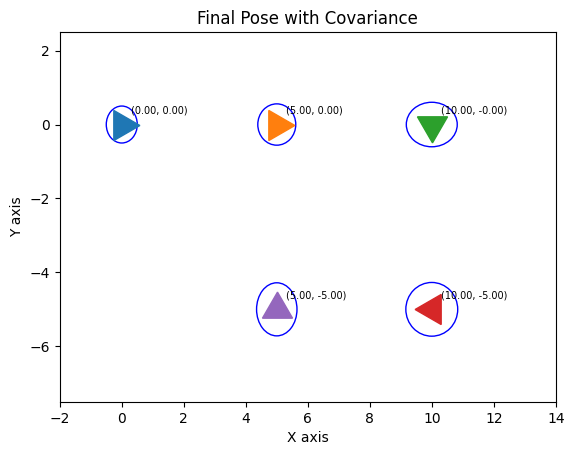

In [ ]:

#Array vazio tamanho 5
final_x = [0] * 5

#Obtenção das poses para plot
for i in range(len(final_x)):
    final_x[i] = results.atPose2(symbol('x', i + 1))

#Criar o plot:
j = 0

for pose in final_x:
    j += 1
    #Extracao da pose
    x = pose.x()
    y = pose.y()
    orientation = np.rad2deg(pose.theta()) - 90

    # Plot das poses
    plt.plot(x, y, marker=(3, 0, orientation), markersize=25, linestyle='dashed')
    plt.text(x + 0.3, y + 0.3, f"({x:.2f}, {y:.2f})", fontsize=7, ha='left')

    # Extrair covariancia
    cov = marginals.marginalCovariance(symbol('x', j))

    # Dados da covariancia
    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    rho = cov[0, 1] / (sigma_x * sigma_y)
    theta_variance = cov[2, 2]

    # Plot da incerteza em formato de elipse
    ellipse = Ellipse(xy=(x, y), width=1 * sigma_x, height=1 * sigma_y,
                      angle=orientation, edgecolor='blue', fc='none', linestyle='-', label='Confidence Ellipse')
    plt.gca().add_patch(ellipse)


# Definição de limites do plot
plt.xlim([-2, 14])
plt.ylim([-7.5, 2.5])
# plt.xlim([-20, 20])
# plt.ylim([-20.5, 20.5])
plt.title("Final Pose with Covariance")
plt.xlabel("X axis")
plt.ylabel("Y axis")

# Plot!
plt.show()


##Notas:

Tutoriais mais avançados com diferentes tópicos podem ser encontrados no [repositório Github](https://github.com/gtbook/gtsam-examples/tree/main) do gtbook. Neste caso foi apenas realizada optimização em batch, mas é possível realizar optimização incremental utilizando o algoritmo [ISAM2](https://www.cs.cmu.edu/~kaess/pub/Kaess12ijrr.pdf), que o GTSAM suporta nativamente.

Para além disso, é possível encontrar exemplos de outras aplicações, como Kalman Filters e SFM.

#Como criar o nosso próprio factor?

O GTSAM não possui *factors* para todos os sensores, e por vezes é necessário criarmos os nossos próprios *factors*, para modelarmos o nosso problema da forma mais adequada possível.

Neste exemplo vamos ver como criar um *factor* representativo de uma medida de posição, como por exemplo o GPS.

Com um sensor de posição, o nosso objetivo é diminuir o erro entre a posição estimada ($x, y$) e a posição medida ($m_{x}, m_{y}$). Desta forma, podemos dizer que o nosso objetivo é encontrar sempre o mínimo da seguinte função de custo:

$$erro = [x -m_{x}, y - m_{y}]$$


In [ ]:
# # TEMOS UM PROBLEMA; PARECE QUE NoiseModelFactor1 NÃO EXISTE PARA PYTHON, mas existe em : https://gtsam.org/doxygen/4.0.0/a03767.html

J = np.array([[1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0]])

#FUNFA::
def gps_error(this: gtsam.CustomFactor, values: gtsam.Values,
                            jacobians: Optional[List[np.ndarray]], measurement: gtsam.Point2) -> np.ndarray:
    """
    Custom 2D GPS error function with Point2 measurement.

    :param this: The gtsam.CustomFactor object
    :param values: The current estimate of values in the graph
    :param jacobians: Optional list to hold Jacobians if needed
    :param measurement: The fixed 2D GPS measurement as a gtsam.Point2

    :return: The error vector [x - mx, y - my]
    """
    key = this.keys()[0]  # Retrieve the key for the pose variable
    estimate = values.atPose2(key)  # Extract the Pose2 estimate at the key
    error = np.array([estimate.x() - measurement[0], estimate.y() - measurement[1]])

    # If Jacobians are requested, set the Jacobian matrix
    if jacobians is not None:
        jacobians[0] = J

    return error



##Implementação do nosso GPS factor

Neste caso vamos querer implementar o nosso factor de GPS, para o seguinte cenário:

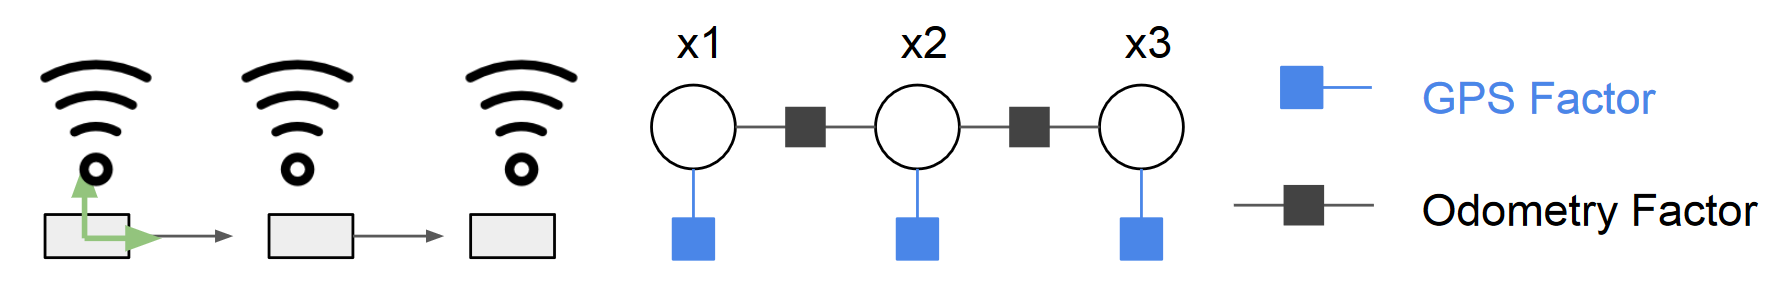

Possuimos medições de GPS em cada instante (x1, x2 e x3), e possuimos informação estimada da odometria entre cada instante.

In [ ]:

# Create a factor graph container
graph1 = gtsam.NonlinearFactorGraph()

# Odometry measurement noise model (covariance matrix)
odom_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.1]))

# Add odometry factors (Between factors between consecutive poses)
graph1.add(gtsam.BetweenFactorPose2(symbol('x', 1), symbol('x', 2), Pose2(5, 0, 0), odom_model))
graph1.add(gtsam.BetweenFactorPose2(symbol('x', 2), symbol('x', 3), Pose2(5, 0, 0), odom_model))

# GPS measurement noise model (2-dimensional for X-Y position)
gps_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([1.0, 1.0]))


# Define GPS measurements as Point2 objects
gps_measurements = [gtsam.Point2(0, 0), gtsam.Point2(5, 0), gtsam.Point2(10, 0)]

# Add GPS factors with global position information (using CustomFactor with error_2d_gps_with_point2)
for k, measurement in enumerate(gps_measurements):
    gf = gtsam.CustomFactor(gps_model, [symbol('x', k + 1)],
                            partial(gps_error, measurement=measurement))
    graph1.add(gf)


# Print factor graph for verification
print("\nFactor Graph:")
graph1.print()

# Initialize variable values for optimization
# Adding some random noise to the initial values (perturbations from ground truth)
initials = gtsam.Values()
initials.insert(symbol('x', 1), Pose2(0.2, -0.3, 0.2))
initials.insert(symbol('x', 2), Pose2(5.1, 0.3, -0.1))
initials.insert(symbol('x', 3), Pose2(9.9, -0.1, -0.2))

# Print initial values for verification
print("\nInitial Values:")
initials.print()

# Use Gauss-Newton optimization to improve initial values
params = gtsam.GaussNewtonParams()
params.setVerbosity("ERROR")

optimizer = gtsam.GaussNewtonOptimizer(graph1, initials, params)
results = optimizer.optimize()

# Print final optimized values
print("\nFinal Results:")
results.print()

# Calculate and print marginal covariances for each pose
marginals = gtsam.Marginals(graph1, results)
print("\nCovariance Results:")
print("x1 covariance:\n", marginals.marginalCovariance(symbol('x', 1)))
print("x2 covariance:\n", marginals.marginalCovariance(symbol('x', 2)))
print("x3 covariance:\n", marginals.marginalCovariance(symbol('x', 3)))


Factor Graph:
NonlinearFactorGraph: size: 5

Factor 0: BetweenFactor(x1,x2)
  measured:  (5, 0, 0)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 1: BetweenFactor(x2,x3)
  measured:  (5, 0, 0)
  noise model: diagonal sigmas [0.5; 0.5; 0.1];

Factor 2: CustomFactor on x1
  noise model: unit (2) 

Factor 3: CustomFactor on x2
  noise model: unit (2) 

Factor 4: CustomFactor on x3
  noise model: unit (2) 


Initial Values:
Values with 3 values:
Value x1: (gtsam::Pose2)
(0.2, -0.3, 0.2)

Value x2: (gtsam::Pose2)
(5.1, 0.3, -0.1)

Value x3: (gtsam::Pose2)
(9.9, -0.1, -0.2)


Final Results:
Values with 3 values:
Value x1: (gtsam::Pose2)
(-4.48009673823e-09, -1.16228632307e-09, 9.13457072179e-12)

Value x2: (gtsam::Pose2)
(5.00000000041, -2.83556543765e-10, 8.48152160009e-12)

Value x3: (gtsam::Pose2)
(10.0000000008, -9.88525542754e-10, 8.48152160094e-12)


Covariance Results:
x1 covariance:
 [[ 4.46153846e-01 -3.00543801e-11  8.47086724e-12]
 [-3.00543801e-11  8.51851852e-01 -1.037